In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch import Tensor

import torchvision
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

from IPython import display

%load_ext autoreload
%autoreload 2

In [2]:
class MasksDataset(data.Dataset):
    def __init__(self, file):
        data = np.load(file)
        
        self.images = self.torch_image(data["images"]) if "images" in data else None
        self.masks  = self.torch_image(data["masks"]) if "masks" in data else None
        self.labels = torch.from_numpy(data["labels"]).cuda() if "labels" in data else None

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return {
            "images": self.images[idx],
            "masks": self.masks[idx] if self.masks is not None else None,
            "labels": self.labels[idx] if self.labels is not None else None
        }
        
    def torch_image(self, img):
        return torch.from_numpy(img.astype(np.float32)).permute(0,3,1,2).cuda()

In [3]:
dir = "data/fashion-masks"

train = MasksDataset(f"{dir}/fashion-masks-train.npz")
dev = MasksDataset(f"{dir}/fashion-masks-dev.npz")
test = MasksDataset(f"{dir}/fashion-masks-test.npz")

In [4]:
def imshow(images, cols=10, figsize=(15,6)):
    n = len(images)
    
    images = images.permute(0,2,3,1).cpu().numpy()
        
    im = images[:,:,:,0]
    
    plt.figure(figsize=figsize)
    
    for i in range(n):
        plt.subplot(n // cols + 1, cols, i + 1)
        plt.axis("off")
        plt.imshow(im[i], cmap="gray")
        
    plt.tight_layout()

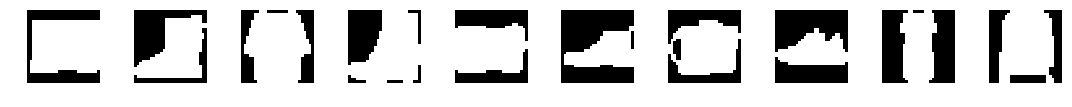

In [5]:
imshow(train.masks[:10])

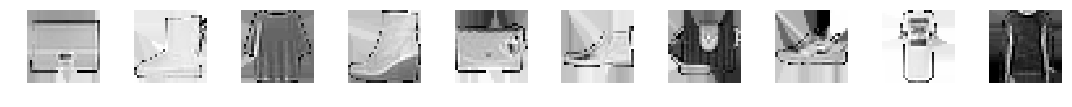

In [6]:
imshow(train.images[:10])

In [7]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

class ConvBlock(nn.Module):
    def __init__(self, inputs=32, outputs=32):
        super(ConvBlock, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(inputs, outputs, 3, padding=1),
            nn.BatchNorm2d(outputs),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
    def forward(self, x):
        return self.model(x)

class DeconvBlock(nn.Module):
    def __init__(self, inputs=32, outputs=32):
        super(DeconvBlock, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(inputs, outputs, 3, padding=1),
            nn.BatchNorm2d(outputs),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
        )
        
    def forward(self, x):
        return self.model(x)

In [8]:
class Trainer:
    def __init__(self, model, lr, criterion, gamma=0.95, step_size=100):
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=step_size, gamma=gamma)
        self.criterion = criterion
        self.losses = []
        
    def fit(self, loader, label_fn, epochs=5, print_each=100):
        self.losses = []
        
        for epoch in range(epochs):
            for i, batch in enumerate(loader):
                self.scheduler.step()

                images = Variable(batch["images"])
                masks = Variable(batch["masks"])

                y_pred = self.model(images)
                loss = self.criterion(y_pred, label_fn(batch))

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                self.losses.append(np.log(loss.data[0]))
                
                if i % 100 == 0 and i > 0:
                    plt.plot(self.losses)
                    display.clear_output(wait=True)
                    display.display(plt.show())

                    print("epoch: {}".format(epoch))
                    print("label_loss: {:0.4f} label_LR: {:0.4f}".format(loss.data[0], self.scheduler.get_lr()[0]))


In [9]:
mask_model = nn.Sequential(
    ConvBlock(1, 64),
    ConvBlock(64, 128),
    DeconvBlock(128, 64),
    DeconvBlock(64, 32),
    
    nn.Conv2d(32, 1, 3, padding=1),
    nn.Sigmoid()
).cuda()

In [10]:
label_model = nn.Sequential(
    ConvBlock(1, 64),
    ConvBlock(64, 64),
    ConvBlock(64, 128),
    ConvBlock(128, 128),
    
    Flatten(),
    nn.Linear(128, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10),
    nn.Softmax(1)
).cuda()

In [11]:
BATCH_SIZE = 256
train_loader = data.DataLoader(train, batch_size=BATCH_SIZE)

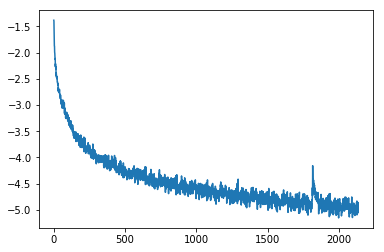

None

epoch: 9
label_loss: 0.0072 label_LR: 0.0034


In [12]:
mask_trainer = Trainer(mask_model, 0.01, nn.MSELoss())
mask_trainer.fit(train_loader, lambda batch: Variable(batch["masks"]).cuda(), epochs=10)

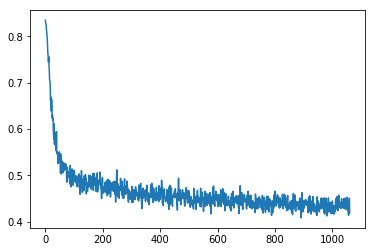

None

epoch: 4
label_loss: 1.5210 label_LR: 0.0003


In [13]:
label_trainer = Trainer(label_model, 0.0005, nn.CrossEntropyLoss())
label_trainer.fit(train_loader, lambda batch: Variable(batch["labels"]).cuda())

In [ ]:

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

mask_optimizer = optim.Adam(mask_model.parameters(), lr=0.1)
label_optimizer = optim.Adam(label_model.parameters(), lr=0.01)


mask_scheduler = optim.lr_scheduler.StepLR(mask_optimizer, step_size=100, gamma=0.95)
label_scheduler = optim.lr_scheduler.StepLR(label_optimizer, step_size=50, gamma=0.98)

mask_losses = []
label_losses = []
dev_losses = []

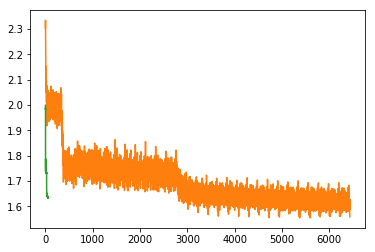

None

epoch: 29
label_loss: 1.5593 label_LR: 0.0008


In [10]:
EPOCHS = 30

for epoch in range(EPOCHS):
    for i, batch in enumerate(train_loader):
        mask_scheduler.step()
        label_scheduler.step()

        images = Variable(batch["images"])
        masks = Variable(batch["masks"])
        labels = Variable(batch["labels"]).cuda()
        
#         y_pred_mask = mask_model(images)
#         mask_loss = mse_loss(y_pred_mask, masks)

#         mask_optimizer.zero_grad()
#         mask_loss.backward()
#         mask_optimizer.step()

#         mask_losses.append(np.log(mask_loss.data[0]))

        y_pred_label = label_model(images)
        label_loss = ce_loss(y_pred_label, labels)
        
        label_optimizer.zero_grad()
        label_loss.backward()
        label_optimizer.step()
        
        label_losses.append(label_loss.data[0])
        
        if i % 100 == 0 and i > 0:
            pred_labels = label_model(Variable(dev[:]["images"]))
            true_labels = Variable(dev[:]["labels"])
            
            dev_loss = ce_loss(pred_labels, true_labels.long())
            dev_losses.append(dev_loss.data[0])

            plt.plot(mask_losses)
            plt.plot(label_losses)
            plt.plot(dev_losses)
            display.clear_output(wait=True)
            display.display(plt.show())
            
            print("epoch: {}".format(epoch))
#             print("mask_loss: {:0.4f}    mask_LR: {:0.4f}".format(mask_loss.data[0], mask_scheduler.get_lr()))
            print("label_loss: {:0.4f} label_LR: {:0.4f}".format(label_loss.data[0], label_scheduler.get_lr()[0]))
            

In [38]:
np.exp(-1.6)

0.20189651799465538

In [82]:
pred_labels = label_model(Variable(dev[:]["images"])).data.cpu().numpy()
true_labels = dev[:]["labels"].cpu().numpy()

In [83]:
np.mean(np.argmax(pred_labels, axis=1) == true_labels)

0.89800000000000002

In [86]:
NUM_TO_COMPARE=2000

dev_compare = dev[:NUM_TO_COMPARE]["masks"]
gen_compare = mask_model(Variable(dev[:NUM_TO_COMPARE]["images"])).data

a = dev_compare.round().byte()
b = gen_compare.round().byte()

(a & b).float().sum() / (a | b).float().sum()

RuntimeError: cuda runtime error (2) : out of memory at c:\anaconda2\conda-bld\pytorch_1519501749874\work\torch\lib\thc\generic/THCStorage.cu:58

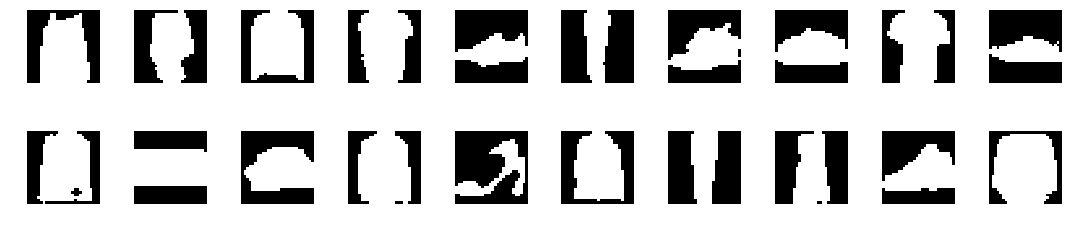

In [62]:
imshow(gen_compare[:20].round(), figsize=(15, 5))

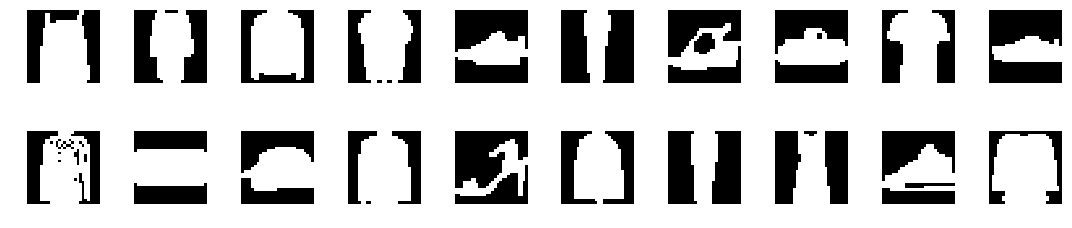

In [63]:
imshow(dev_compare[:20], figsize=(15, 5))

In [ ]:
with open("fashion_masks_test.txt", "w") as test_file:
    numpyed = preds.permute(0,2,3,1).round().byte().numpy()
    for i in range(len(labels)):
        print(labels[i], *numpyed[i].astype(np.uint8).flatten(), file=test_file)